# * Before you start, please make a copy to your drive or elsewhere *

## Setup environments

In [11]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# print("torch-scatter installed")
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# print("torch-sparse installed")
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
# print("torch-geometric installed")

# !pip install ogb

1.12.0


## Load the OGB dataset
See details: https://ogb.stanford.edu/docs/nodeprop/#ogbn-arxiv

In [12]:
import torch_geometric.transforms as T
import torch.nn.functional as F
from ogb.nodeproppred import PygNodePropPredDataset
from ogb.nodeproppred import Evaluator

import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

dataset_name = 'ogbn-arxiv'
dataset = PygNodePropPredDataset(name=dataset_name)
data = dataset[0]

# convert into a networkx object
g = to_networkx(data = data, to_undirected=True)


## (3 points) Check the number of nodes, edges and density of the graph

In [13]:
## -- your code here -- ##
## calculate the number of nodes, edges and density of the graph g
## you can use networkX library

num_nodes = g.number_of_nodes()
num_edges = g.number_of_edges()

numerator = 2 * num_edges
denomenator = num_nodes * (num_nodes - 1)
density = numerator / denomenator

print('Number of nodes: %d, number of edges: %d, density: %g'%(num_nodes, num_edges, density))

Number of nodes: 169343, number of edges: 570407, density: 3.97817e-05


##(5 points) Plot the degree distribution of the graph

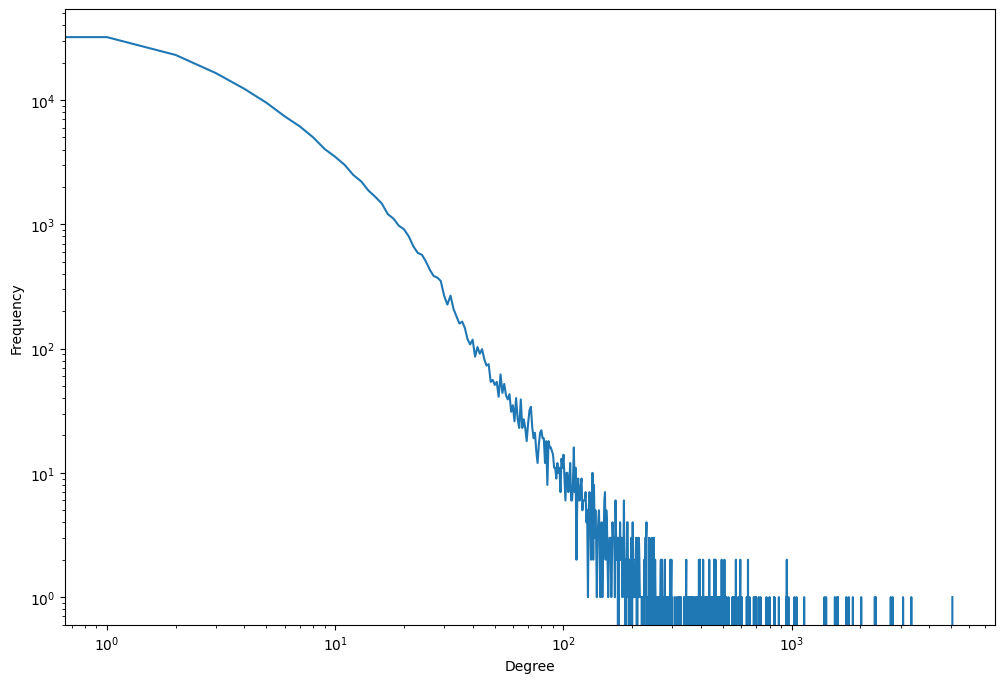

In [14]:
import matplotlib.pyplot as plt
def plot_degree_hist(G):
  freq = nx.degree_histogram(G) 

  plt.figure(figsize=(12,8))
  
  ## -- your code here -- ##
  ## It should be a log-log scale plot
  ## (x-axis: node degree, y-axis: degree frequency)
  degrees = range(len(freq))    
  plt.loglog(degrees, freq)
  # import numpy as np 
  # freq_log = np.log10(freq)
  # degrees_log = np.log10(degrees)
  # plt.plot(degrees_log, freq_log)
  
  plt.xlabel('Degree')
  plt.ylabel('Frequency')

plot_degree_hist(g)

## (5 points) Compute the network diameter

In [15]:
def compute_diameter(G):
  
  ## -- your code here -- ##
  ## If a graph is connected, you just use nx.diameter(.)
  ## If a graph is disconnected, you first extract the largest connected component as subgraph and compute the diameter of it
  ## 
  ## NetworkX functions will be useful such as nx.is_connected(.), nx.connected_components(.), nx.diameter(.)
  ## See https://networkx.org/documentation/stable/reference/algorithms/index.html
  ##
  ## For a large graph, approximations can be helpful (nx.approximation.diameter(.))
  ## See https://networkx.org/documentation/stable/reference/algorithms/approximation.html
  # print(nx.is_connected(g))  # false
  components_generator = nx.connected_components(g)
  component_diameters = []
  
  for components in components_generator:
     graph = g.subgraph(components).copy()
     component_diameters.append(nx.approximation.diameter(graph))
  import numpy as np
  diameter = np.max(component_diameters)
  return diameter

print(compute_diameter(g))

29


##Prepare your dataset

In [16]:
# transform into a sparse tensor
dataset = PygNodePropPredDataset(name=dataset_name,
                                 transform=T.ToSparseTensor())

data = dataset[0]
data.adj_t = data.adj_t.to_symmetric()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
data = data.to(device)
split_idx = dataset.get_idx_split()
train_idx = split_idx['train'].to(device)
print(data)


cuda
Data(num_nodes=169343, x=[169343, 128], node_year=[169343, 1], y=[169343, 1], adj_t=[169343, 169343, nnz=2315598])


## Model design
To investigate GNN-based models can improve the prediction performance, we first implement a simple MLP(Multi-layer Perceptron) model as below.

## (10 points) Complete the forward function

In [17]:
class MLP(torch.nn.Module):
    def __init__(self, c_in, c_hidden, c_out, num_layers, dp_rate):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of the output features. Usually number of classes in classification
            num_layers - Number of hidden layers
            dp_rate - Dropout rate to apply throughout the network
        """
        super(MLP, self).__init__()
        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers-1):
            layers += [
                torch.nn.Linear(in_channels, out_channels)
            ]
            in_channels = c_hidden
        layers += [torch.nn.Linear(in_channels, c_out)]
        self.layers = torch.nn.Sequential(*layers)
        self.softmax = torch.nn.LogSoftmax()
        self.dropout = dp_rate

    def forward(self, x):

      ## --- your code here --- ##
      ## For each layer (use self.layers), add ReLU activation (torch.nn.functional.relu) and 
      ##   dropout (torch.nn.functional.dropout) when it is in training mode (you can use self.training)
      ## See https://pytorch.org/docs/stable/nn.functional.html
       for layer in self.layers:
        out = layer(x)
        out = F.relu(out)
        out = F.dropout(out, p=self.dropout, training=self.training)
        x = out 
        return out

Now, train and test the model

## (7 points) Complete the train / test function

In [18]:
def train(model, data, train_idx, optimizer, loss_fn):
    model.train()
    optimizer.zero_grad()

    ## fill in the parameters of each function
    # out = model(...)
    # loss = loss_fn(...)
    train_x = data.x[train_idx]
    out = model(train_x)
    log_softmax = F.log_softmax(out, dim=1)
    
    train_y = data.y[train_idx] 
    train_y = torch.squeeze(train_y, dim=1)
    loss = loss_fn(log_softmax, train_y)      
    
    loss.backward()
    optimizer.step()

    return loss.item()

def test(model, data, split_idx, evaluator):
    model.eval()

    ## fill in the parameters 
    # out = model(...)
    out = model(data.x)

    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': data.y[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': data.y[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': data.y[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    return train_acc, valid_acc, test_acc

Evaluate the model performance

In [19]:
import copy

args = {
    'device': device,
    'num_layers': 3,
    'hidden_dim': 256,
    'dropout': 0.5,
    'lr': 0.01,
    'epochs': 100,
}

model = MLP(data.num_features, args['hidden_dim'],
            dataset.num_classes, args['num_layers'],
            args['dropout']).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = F.nll_loss
evaluator = Evaluator(name='ogbn-arxiv')

best_model = None
best_valid_acc = 0

for epoch in range(1, 1 + args["epochs"]):
  loss = train(model, data, train_idx, optimizer, loss_fn)

  result = test(model, data, split_idx, evaluator)
  train_acc, valid_acc, test_acc = result
  if valid_acc > best_valid_acc:
    best_valid_acc = valid_acc
    best_model = copy.deepcopy(model)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')

best_result = test(best_model, data, split_idx, evaluator)
train_acc, valid_acc, test_acc = best_result
print(f'Best model: '
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * valid_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 5.5757, Train: 3.56%, Valid: 5.60% Test: 5.87%
Epoch: 02, Loss: 5.4130, Train: 4.68%, Valid: 7.45% Test: 7.67%
Epoch: 03, Loss: 5.2815, Train: 6.02%, Valid: 9.62% Test: 9.90%
Epoch: 04, Loss: 5.1538, Train: 7.52%, Valid: 12.05% Test: 12.58%
Epoch: 05, Loss: 5.0382, Train: 9.31%, Valid: 14.90% Test: 15.93%
Epoch: 06, Loss: 4.9365, Train: 11.50%, Valid: 18.07% Test: 19.74%
Epoch: 07, Loss: 4.8411, Train: 13.68%, Valid: 21.59% Test: 23.67%
Epoch: 08, Loss: 4.7749, Train: 15.42%, Valid: 24.45% Test: 26.83%
Epoch: 09, Loss: 4.7187, Train: 16.45%, Valid: 26.37% Test: 28.59%
Epoch: 10, Loss: 4.6710, Train: 17.05%, Valid: 27.67% Test: 29.33%
Epoch: 11, Loss: 4.6359, Train: 18.69%, Valid: 28.49% Test: 28.80%
Epoch: 12, Loss: 4.6062, Train: 22.32%, Valid: 28.95% Test: 27.75%
Epoch: 13, Loss: 4.5980, Train: 25.92%, Valid: 29.21% Test: 26.53%
Epoch: 26, Loss: 4.3753, Train: 30.79%, Valid: 29.35% Test: 25.76%
Epoch: 27, Loss: 4.3505, Train: 33.15%, Valid: 32.70% Test: 29.20%
Epoch:



##Q1. (30 points) Submit the completed notebook file (File > Download > Download .ipynb)




#Submit the document (.docx) that answer the following questions. <br> 
###**- For the following questions, you should include the modified or added part of your code in Q1.** <br><br>


## GNN model
Now, you will design GNN model and evaluate the prediction performance as above. <br>
Write down your code below and train the model using the same parameters (args.num_layers, args_dropout, etc.). <br>
You can use PyG library for GCN and GraphSAGE operater (https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#convolutional-layers) as below. <br><br>




In [20]:
from torch_geometric.nn import GCNConv, SAGEConv

args = {
    'device': device,
    'num_layers': 2,
    'hidden_dim': 16,
    'dropout': 0.5,
    'lr': 0.01,
    'epochs': 100,
}

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = F.nll_loss
evaluator = Evaluator(name='ogbn-arxiv')

class GNN(torch.nn.Module):
    def __init__(self, c_in, c_hidden, c_out, num_layers, dp_rate):
        
        super(GNN, self).__init__()
        
        # --- Your code here --- #
        # self.conv1 = GCNConv(data.num_features, 16)
        # self.conv2 = GCNConv(16, int(data.num_classes))
        self.conv1 = GCNConv(c_in, c_hidden)
        self.conv2 = GCNConv(c_hidden, c_out)

    def forward(self, x, adj_t):
        
        # --- Your code here --- #
        # x, edge_index = data.x, data.edge_index
        x, edge_index = data.x, adj_t
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        out = F.log_softmax(x, dim=1)
        return out
    
model = GNN(data.num_features, args['hidden_dim'],
            dataset.num_classes, args['num_layers'],
            args['dropout']).to(device)

TypeError: __init__() missing 5 required positional arguments: 'c_in', 'c_hidden', 'c_out', 'num_layers', and 'dp_rate'


##Q2. (20 points) How was the prediction performance of GCN model? Compare with MLP model and discuss about the results. <br><br>

##Q3. (20 points) How was the prediction performance of GraphSAGE? Use different aggregation function (use parameter 'aggr' in SAGEConv) and compare the performances. Discuss about the results. <br><br>

##Q4. (20 points) For a GCN model, change the number of layers (args.num_layers) into 10. How is the performance now? Discuss about the results. <br><br>

##Q5. (10 points) Suggest your strategy to improve the performance. Hint: You can use the building blocks for DNN as we learned in our class (Refer https://pytorch.org/docs/stable/nn.html). <br><br>